<a href="https://colab.research.google.com/github/zconomy/1.001PS4/blob/main/PS4_Dubai_air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import folium
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=AwzE11QmDG7SVx_E6dgDiiCmWo7D4rh5joW0xMcbEyU&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhXQO4trDoUc6WVnG2DxNffKmFOvZg5zvJQJm46kx5G9wfW6mOMpP8

Successfully saved authorization token.


In [2]:
# This is needed in python to add layers to Folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [68]:

# Import the MODIS land surface temperature collection.
no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2')

# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2022-01-01'

# Selection of appropriate bands and dates for LST.
no2 = no2.select('NO2_column_number_density').filterDate(i_date, f_date)

# Define the urban location of interest as a point near New Delhi
u_lon = 	28.644800#25.276987
u_lat = 	77.216721#55.296249
u_poi = ee.Geometry.Point(u_lon, u_lat)

scale = 1000  # scale in meters

# Get the data for the pixel intersecting the point in urban area.
no2_u_poi = no2.getRegion(u_poi, scale).getInfo()
no2_u_poi[:5]



[['id', 'longitude', 'latitude', 'time', 'NO2_column_number_density'],
 ['20180710T110244_20180710T130059_1',
  28.642782834150943,
  77.21469024649348,
  1531220559000,
  8.114703541503435e-05],
 ['20180710T124716_20180710T144100_1',
  28.642782834150943,
  77.21469024649348,
  1531226831000,
  None],
 ['20180710T142721_20180710T161927_1',
  28.642782834150943,
  77.21469024649348,
  1531232836000,
  None],
 ['20180710T160646_20180710T175900',
  28.642782834150943,
  77.21469024649348,
  1531238801000,
  None]]

In [69]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

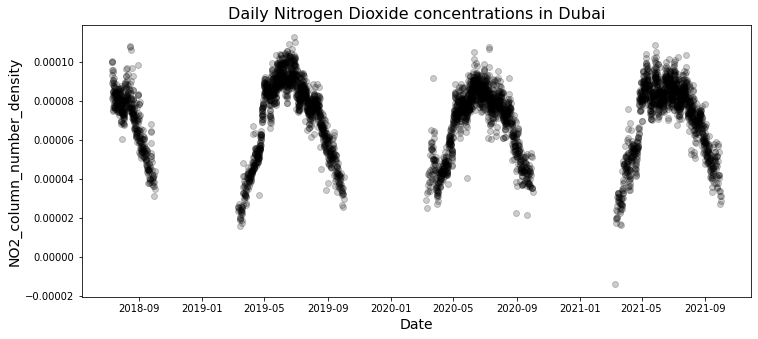

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

no2_df_urban = ee_array_to_df(no2_u_poi,['NO2_column_number_density'])
no2_df_urban.head()

# Subplots.
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(no2_df_urban['datetime'], no2_df_urban['NO2_column_number_density'],
           c='black', alpha=0.2, label='Urban (data)')

ax.set_title('Daily Nitrogen Dioxide concentrations in New Delhi', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('NO2_column_number_density', fontsize = 14)
# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET#bands
plt.show()


In [74]:
# Define a region of interest with a buffer zone of 1000 km around new delhi.
roi = u_poi.buffer(1e6)

# Reduce the LST collection by mean.
no2_img = no2.mean()

from IPython.display import Image

# Create a URL to the styled image for a region
url = no2_img.getThumbUrl({
    'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9b1f261a226878df142141d077ddecb-0428a1dfdbc4fd11b1c88d3ed3ae7d75:getPixels

Please wait while the thumbnail loads, it may take a moment...
